In [1]:
import os
import sys
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.stats import norm

sys.path.insert(0,'..')
from src.stochastic_process import wienerprocess
from src.sde_solver import eulerMaruyama

In [2]:
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

# Monte Carlo method for pricing european options

The idea behind Monte Carlo methods is to repeat random sampling in order to obtain numerical results. This is usually done via simulation of random components in the model. In option pricing, the randomness is introduced by the price path for the underlying, that is the geometric Brownian motion in case of the Black-Scholes model.

The price of an European call option today is the discounted expected value

$$
V(0) = e^{-r T} \mathbb{E}\left[(S(T) - K)^+\right],
$$

where $r$ denotes the risk-free rate, $T$ is the maturity, and $K$ the strike. 

The goal of the Monte Carlo method is to approximate the expectation in the above expression using simulation. For this we need a sufficiently large number of samples $m \in \mathbb{N}$ to represent the underlying. The samples in our case are Wiener paths $W_t^i$ for $i=1,\ldots, m$. Using a numerical scheme such as the Euler-Maruyama method for solving SDEs we then obtain approximations $(S_n^i)_{n=1, \ldots, N}$ for each Wiener path $W_t^i$. We obtain the (not yet discounted) option value by averaging

$$
\mathbb{E}\left[(S(T) - K)^+\right] \approx \frac{1}{m} \sum_{i=1}^{m} (S^i_N - K)^+.
$$

## Two sources of error

So there are two error terms here, namely

1. the step size $\tau = T/N$ with which the SDE solver (e.g. Euler-Maruyama) operates, and
2. the number of Monte Carlo samples $m \in \mathbb{N}$ to approximate the expectation.

**Goal of the notebook**

It is clear that higher values for both $N \in \mathbb{N}$ and $m \in \mathbb{N}$ lead to smaller errors. The aim of this notebook is to investigate the order of convergence in the time steps $N$ and the number of Monte Carlo samples $m$.

In [3]:
def MCEuropean(n_paths, s0, K, r, sigma, T, N=None):
    if N is None:
        wiener_T = np.sqrt(T) * np.random.randn(n_paths)
        underlying_T = s0 * np.exp((r - sigma**2 / 2) * T + sigma * wiener_T)
    else:
        underlying_T = eulerMaruyama(r, sigma, s0, N, T, n_paths)
    
    opt_vals = np.exp(-r * T) * payoff(underlying_T)
    
    val = np.mean(opt_vals)
    variance = np.var(opt_vals) / n_paths

    return val, variance

## Black-Scholes formula

In order to test and measure the error of our Monte Carlo method we need the analytical Black-Scholes solution, which is given by

$$
C(S, t) = S \Phi(d_1) - K e^{-r(T-t)} \Phi (d_2)
$$

for a European call, and 

$$
P(S, t) = K e^{-r (T-t)} \Phi(-d_2) - S \Phi(-d_1)
$$

for a European Put option, with

$$
d_{1, 2} = \frac{\ln (S/K) + (r \pm \sigma^2 / 2)(T-t)}{\sigma \sqrt{T-t}}
$$

and $\Phi$ being the cummulative of the standard normal distribution.

In [4]:
def BlackScholes(S, t, K, r, sigma, T, option):    
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * (T - t)) / np.sqrt(T - t) / sigma
    d2 = (np.log(S / K) + (r - sigma ** 2 / 2) * (T - t)) / np.sqrt(T - t) / sigma
    
    if option == 'call':
        val = S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
    elif option == 'put':
        val = K * np.exp(-r * (T - t)) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return val

## Option parameters

Let's fix some option parameters for a European call and test the Monte Carlo method by comparing with the one we get from the Black-Scholes formula.

In [5]:
s0 = 12
K = 10
r = 0.3
sigma = 0.1
T = 1
option = 'call'

if option == 'call':
    payoff = lambda s: np.maximum(s - K, 0)
elif option == 'put':
    payoff = lambda s: np.maximum(K - s, 0)

In [6]:
today = 0
bs_val = BlackScholes(s0, today, K, r, sigma, T, option)
print(f"Black-Scholes: {bs_val:.3f}")

Black-Scholes: 4.592


In [7]:
n_paths = 1000
mc_val, mc_var = MCEuropean(n_paths, s0, K, r, sigma, T)
print(f"Monte Carlo: {mc_val:.3f}")
print(f"Variance: {mc_var:.2e}")

Monte Carlo: 4.566
Variance: 1.47e-03


**Note** that the Monte Carlo result changes when we run the cell again since it is based on randomness.

# Step size error

We will investigate the role of the step size $\tau = T / N$ by varying the number of time steps $N \in \mathbb{N}$. Let's fix $m = 500.000$ Monte Carlo samples and use variable number of time steps $N = 2^k$ for $k=1,\ldots,8$.

In [8]:
m = 500_000
time_steps = np.array([2**k for k in range(1, 9)])

errors, rmse = [], []
for n in tqdm(time_steps):
    mc_val, var = MCEuropean(m, s0, K, r, sigma, T, N=n)
    errors.append(np.abs(mc_val - bs_val))
    rmse.append(np.sqrt(var + (mc_val - bs_val)**2))

  0%|          | 0/8 [00:00<?, ?it/s]

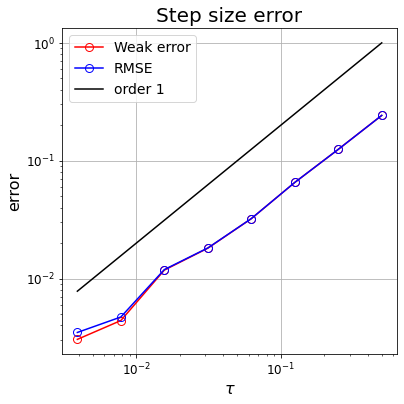

In [9]:
fig = plt.figure(figsize=(6, 6))
plt.loglog(T / time_steps, errors, 'ro-', markersize=8, fillstyle='none', label='Weak error')
plt.loglog(T / time_steps, rmse, 'bo-', markersize=8, fillstyle='none', label='RMSE')
plt.loglog(T / time_steps, 2 * (T / time_steps)**1.0, 'k', label='order 1')
plt.xlabel(r'$\tau$')
plt.ylabel('error')
plt.title('Step size error', size=20)
plt.grid()
plt.legend();

What we can see here is basically the **weak order of $1$**

$$
| \mathbb{E}\, [F(X(t_n))] - \mathbb{E} \, [F(X_n)]| \in \mathcal{O}(\tau^{\gamma})
$$

for the Euler-Maruyama method with the function $F$ being the payoff function here.

# Sample size error

In order to investigate the number of Monte Carlo samples $m \in \mathbb{N}$ versus the error, we could choose one sufficiently large number of time steps $N \in \mathbb{N}$ for the SDE solver and repeat the process by varying the number number of samples $m \in \mathbb{N}$. However, we have access to the exact solution of the SDE, namely the geometric Brownian motion 

$$
S_t = S_0 \exp \left[\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right].
$$

Thus there is no need to solve the SDE numerically. We will use Monte Carlo sample sizes $m = 10^k$ for $k=1,\,1.5,\ldots,6.5,\,7$ to investigate their impact on the error.

In [10]:
sample_sizes = np.array([int(10 ** k) for k in np.arange(1, 7.5, 0.5)])

errors, rmse = [], []
for m in sample_sizes:
    mc_val, var = MCEuropean(m, s0, K, r, sigma, T)
    errors.append(np.abs(mc_val - bs_val))
    rmse.append(np.sqrt(var + (mc_val - bs_val)**2))

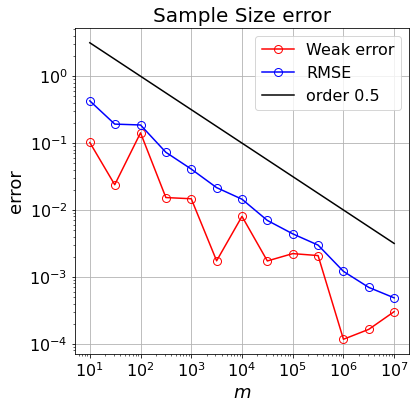

In [11]:
fig = plt.figure(figsize=(6, 6))
plt.loglog(sample_sizes, errors, 'ro-', markersize=8, fillstyle='none', label='Weak error')
plt.loglog(sample_sizes, rmse, 'bo-', markersize=8, fillstyle='none', label='RMSE')
plt.loglog(sample_sizes, 10*sample_sizes**-0.5, 'k', label='order 0.5')
plt.xticks(size=16); plt.yticks(size=16);
plt.xlabel(r'$m$', size=18), plt.ylabel('error', size=18)
plt.title('Sample Size error', size=20); plt.grid()
plt.legend(fontsize=16, loc='best');

This result is well known; the error for a Monte Carlo approximation is of the order $\sqrt{m}$ where $m \in \mathbb{N}$ is the number of samples used. Therefore, in summary, if we want to **reduce the error of our Monte Carlo option value approximation by a factor of 10**, we could use 

* $100$ times more Monte Carlo Samples $m \in \mathbb{N}$, **or**
* use $10$ times more number of time steps $N \in \mathbb{N}$ in the SDE solver.